# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [126]:
# import libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import sqlite3
import sqlalchemy
import time
import matplotlib.pyplot as plt

import re
import nltk
nltk.download(['punkt', 'wordnet','stopwords'])


from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import GridSearchCV,train_test_split,RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.ensemble import VotingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,classification_report,precision_recall_fscore_support




[nltk_data] Downloading package punkt to /home/ania/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ania/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ania/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [321]:
# load data from database
sql_engine = create_engine('sqlite:///DisasterResponse.db',echo=False)
connection = sql_engine.raw_connection()  #had to have this line otherwise froze

table_name = str(sql_engine.table_names()[0])
print(table_name)

df = pd.read_sql("SELECT * FROM '{}'".format(table_name),con=connection)

X = df[['id','message','original','genre']]  #remove original
Y = df.drop(columns=['id','message','original','genre'])

data


In [322]:
sql_engine.table_names()

['data']

In [323]:
df.shape

(26216, 40)

In [324]:
df.head(2)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0


In [325]:
X.head(2)

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct


In [326]:
Y.head(2)

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [327]:
Y.describe()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.0,...,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,0.773650,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,0.032804,0.0,...,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584
std,0.435276,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,0.178128,0.0,...,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [328]:
Y.max()

related                   2
request                   1
offer                     1
aid_related               1
medical_help              1
medical_products          1
search_and_rescue         1
security                  1
military                  1
child_alone               0
water                     1
food                      1
shelter                   1
clothing                  1
money                     1
missing_people            1
refugees                  1
death                     1
other_aid                 1
infrastructure_related    1
transport                 1
buildings                 1
electricity               1
tools                     1
hospitals                 1
shops                     1
aid_centers               1
other_infrastructure      1
weather_related           1
floods                    1
storm                     1
fire                      1
earthquake                1
cold                      1
other_weather             1
direct_report       

In [329]:
(df['id'].value_counts()==1).sum() #some ids doint more than one message ~70

26144

In [330]:
df.shape

(26216, 40)

(array([1., 0., 0., ..., 1., 1., 2.]),
 array([2.00000000e+00, 3.16396154e+00, 4.32792308e+00, ...,
        3.02626721e+04, 3.02638360e+04, 3.02650000e+04]),
 <a list of 26000 Patch objects>)

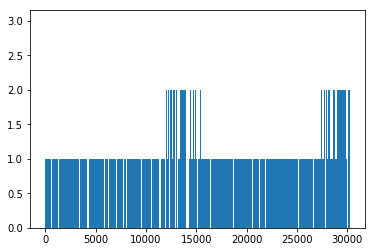

In [331]:
plt.hist(df['id'],bins=26000)

(array([ 6122.,     0.,     0.,     0.,     0., 19906.,     0.,     0.,
            0.,   188.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

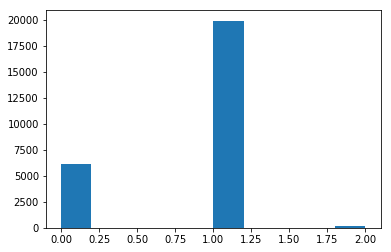

In [332]:
plt.hist(Y['related'])

(array([    0.,     0.,     0.,     0.,     0., 26216.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

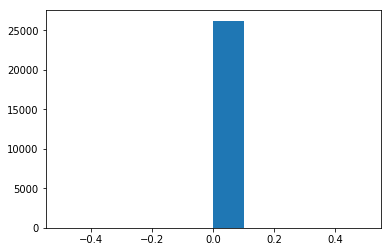

In [333]:
plt.hist(Y['child_alone'])

In [334]:
Y.sum(axis=1)

0         1
1         5
2         1
3         8
4         1
5         0
6         3
7         6
8         0
9         6
10       15
11        0
12        5
13        5
14        1
15        9
16        7
17        0
18        0
19        3
20        1
21        5
22        5
23        4
24        1
25        0
26        8
27        9
28        6
29        5
         ..
26186     3
26187     4
26188     3
26189     0
26190     0
26191     3
26192     1
26193     5
26194     5
26195     0
26196     1
26197     6
26198     5
26199     3
26200     0
26201     3
26202     1
26203     6
26204     0
26205     6
26206     3
26207     3
26208     1
26209     0
26210     1
26211     0
26212     0
26213     1
26214     3
26215     1
Length: 26216, dtype: int64

In [335]:
Y.sum(axis=1).min()

0

In [336]:
Y.sum(axis=1).max()

27

In [337]:
Y[Y.sum(axis=1)==0].describe()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,6122.0,6122.0,6122.0,6122.0,6122.0,6122.0,6122.0,6122.0,6122.0,6122.0,...,6122.0,6122.0,6122.0,6122.0,6122.0,6122.0,6122.0,6122.0,6122.0,6122.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(array([6.122e+03, 5.121e+03, 6.310e+02, 0.000e+00, 3.609e+03, 2.276e+03,
        2.956e+03, 0.000e+00, 1.903e+03, 1.347e+03, 8.800e+02, 0.000e+00,
        5.770e+02, 3.440e+02, 1.830e+02, 0.000e+00, 1.070e+02, 5.700e+01,
        3.800e+01, 0.000e+00, 2.000e+01, 8.000e+00, 1.200e+01, 0.000e+00,
        7.000e+00, 5.000e+00, 4.000e+00, 0.000e+00, 4.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([ 0.  ,  0.75,  1.5 ,  2.25,  3.  ,  3.75,  4.5 ,  5.25,  6.  ,
         6.75,  7.5 ,  8.25,  9.  ,  9.75, 10.5 , 11.25, 12.  , 12.75,
        13.5 , 14.25, 15.  , 15.75, 16.5 , 17.25, 18.  , 18.75, 19.5 ,
        20.25, 21.  , 21.75, 22.5 , 23.25, 24.  , 24.75, 25.5 , 26.25,
        27.  ]),
 <a list of 36 Patch objects>)

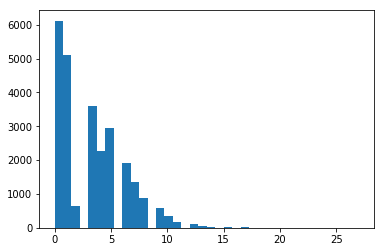

In [338]:
plt.hist(Y.sum(axis=1),bins=36)

In [339]:
col =list(Y.columns)

In [340]:
col

['related',
 'request',
 'offer',
 'aid_related',
 'medical_help',
 'medical_products',
 'search_and_rescue',
 'security',
 'military',
 'child_alone',
 'water',
 'food',
 'shelter',
 'clothing',
 'money',
 'missing_people',
 'refugees',
 'death',
 'other_aid',
 'infrastructure_related',
 'transport',
 'buildings',
 'electricity',
 'tools',
 'hospitals',
 'shops',
 'aid_centers',
 'other_infrastructure',
 'weather_related',
 'floods',
 'storm',
 'fire',
 'earthquake',
 'cold',
 'other_weather',
 'direct_report']

In [341]:
df.shape

(26216, 40)

In [342]:
df[df[col].sum(axis=1)==0].head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
5,14,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,17,"I would like to receive the messages, thank you",Mwen ta renmen jouin messag yo. Merci,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,21,I am in Petionville. I need more information r...,M nan pv mvle plis enfomasyon sou 4636,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,28,are you going to call me or do you want me to ...,Eske se rele nap relem oubyen se mwen kap rele...,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,30,I don't understand how to use this thing 4636.,Mwen pa konprann koman pou m itilize bagay 463...,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [343]:
df['genre'].value_counts()

news      13054
direct    10766
social     2396
Name: genre, dtype: int64

In [344]:
df[df[col].sum(axis=1)==0]['genre'].value_counts()

direct    3452
news      2365
social     305
Name: genre, dtype: int64

In [345]:
df[col].head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [346]:
df[col].sum(axis=1)

0         1
1         5
2         1
3         8
4         1
5         0
6         3
7         6
8         0
9         6
10       15
11        0
12        5
13        5
14        1
15        9
16        7
17        0
18        0
19        3
20        1
21        5
22        5
23        4
24        1
25        0
26        8
27        9
28        6
29        5
         ..
26186     3
26187     4
26188     3
26189     0
26190     0
26191     3
26192     1
26193     5
26194     5
26195     0
26196     1
26197     6
26198     5
26199     3
26200     0
26201     3
26202     1
26203     6
26204     0
26205     6
26206     3
26207     3
26208     1
26209     0
26210     1
26211     0
26212     0
26213     1
26214     3
26215     1
Length: 26216, dtype: int64

In [347]:
#df[col].sum(axis=1)
df['count'] = df[col].sum(axis=1)

In [348]:
#df['count']
df[df['count']==0].head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,count
5,14,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,17,"I would like to receive the messages, thank you",Mwen ta renmen jouin messag yo. Merci,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,21,I am in Petionville. I need more information r...,M nan pv mvle plis enfomasyon sou 4636,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,28,are you going to call me or do you want me to ...,Eske se rele nap relem oubyen se mwen kap rele...,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,30,I don't understand how to use this thing 4636.,Mwen pa konprann koman pou m itilize bagay 463...,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [349]:
df[df['count']==0].index

Int64Index([    5,     8,    11,    17,    18,    25,    30,    32,    52,
               66,
            ...
            26177, 26183, 26189, 26190, 26195, 26200, 26204, 26209, 26211,
            26212],
           dtype='int64', length=6122)

In [350]:
df[df['count']==0].iloc[5]

id                                                        37
message                   Can you tell me about this service
original                  Can you tell me about this service
genre                                                 direct
related                                                    0
request                                                    0
offer                                                      0
aid_related                                                0
medical_help                                               0
medical_products                                           0
search_and_rescue                                          0
security                                                   0
military                                                   0
child_alone                                                0
water                                                      0
food                                                       0
shelter                 

In [351]:
np.random.choice([10,32,15,11,0,9], 3)

array([15, 10,  9])

In [352]:
import numpy as np
x=np.random.choice(list(df[df['count']==0].index),10)
print(df.loc[x].message.values)
#print(df[col].loc[x])


['Where the women will be able to participate in this reamenagement they talking about. '
 'You COIL are a man very sage for me and charming '
 'The project, which started in March 2001, is supporting seven co-operative farms in Kosan County (7,426 farmers, 3,121 ha of arable land and a population of 15,019 persons).'
 'He described the ruling party as monolithic, dictatorial and militarist.'
 'I would like advice on how I can live.'
 'where do I go and get the vaccine? '
 "Since Khatami's 1997 election, his pro-reform supporters have scored major electoral wins in municipal and especially parliamentary elections, winning a majority in the legislature in February, the report said."
 "NOTES: This message isn't important"
 'Is the aimmigration office functioning? '
 'I need the little job to take care myself. Good bless you thank so much. ']


In [353]:
df[df.related==2].describe()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,count
count,188.000000,188.0,188.0,188.0,188.0,188.0,188.0,188.0,188.0,188.0,...,188.0,188.0,188.0,188.0,188.0,188.0,188.0,188.0,188.0,188.0
mean,11703.340426,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
std,5479.507080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,146.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
25%,8956.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
50%,13770.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
75%,14376.750000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
max,29126.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [354]:
df[df.related==2][['message','original']].head()

,message,original
117,Dans la zone de Saint Etienne la route de Jacm...,Nan zon st. etine rout jakmel la bloke se mize...
219,. .. i with limited means. Certain patients co...,t avec des moyens limites. Certains patients v...
305,The internet caf Net@le that's by the Dal road...,Cyber cafe net@le ki chita rout de dal tou pr ...
460,"Bonsoir, on est a bon repos aprs la compagnie ...",Bonswa nou nan bon repo apri teleko nan wout t...
576,URGENT CRECHE ORPHANAGE KAY TOUT TIMOUN CROIX ...,r et Salon Furterer. mwen se yon Cosmtologue. ...


In [355]:
df.isnull().sum()

id                            0
message                       0
original                  16046
genre                         0
related                       0
request                       0
offer                         0
aid_related                   0
medical_help                  0
medical_products              0
search_and_rescue             0
security                      0
military                      0
child_alone                   0
water                         0
food                          0
shelter                       0
clothing                      0
money                         0
missing_people                0
refugees                      0
death                         0
other_aid                     0
infrastructure_related        0
transport                     0
buildings                     0
electricity                   0
tools                         0
hospitals                     0
shops                         0
aid_centers                   0
other_in

In [160]:
# import matplotlib.pyplot as plt
# plt.hist(df['index'])

In [356]:
df_twitter = pd.read_csv('Twitter-sentiment-self-drive-DFE.csv')

In [357]:
df_twitter.head()

,Unnamed: 0,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,our_id,sentiment_gold,sentiment_gold_reason,text
0,0,724227031,True,golden,236,NaN,5,0.7579,10001,5\n4,Author is excited about the development of the...,Two places I'd invest all my money if I could:...
1,1,724227032,True,golden,231,NaN,5,0.8775,10002,5\n4,Author is excited that driverless cars will be...,Awesome! Google driverless cars will help the ...
2,2,724227033,True,golden,233,NaN,2,0.6805,10003,2\n1,The author is skeptical of the safety and reli...,If Google maps can't keep up with road constru...
3,3,724227034,True,golden,240,NaN,2,0.8820,10004,2\n1,The author is skeptical of the project's value.,Autonomous cars seem way overhyped given the t...
4,4,724227035,True,golden,240,NaN,3,1.0000,10005,3,Author is making an observation without expres...,Just saw Google self-driving car on I-34. It w...


In [358]:
df_twitter.shape

(7156, 12)

# Read data

In [4]:
# load data from database
sql_engine = create_engine('sqlite:///DisasterResponse.db',echo=False)
connection = sql_engine.raw_connection()  #had to have this line otherwise froze

table_name = str(sql_engine.table_names()[0])
print(table_name)

df = pd.read_sql("SELECT * FROM '{}'".format(table_name),con=connection)

data


In [5]:
col = list(set(df.columns)-set(df[['id','message','original','genre']]))
len(col)

36

In [6]:

df = df[(df.related!=2) & (df[col].sum(axis=1)!=0)]
#df = df[(df.related!=2)] #this lowered the f1 from 0.71 to 0.66
print(df.shape)
X = df[['message']]  #drop original message, and id, also genre since at the end only message text get into the app
Y = df.drop(columns=['id','message','original','genre'])

#df[['message']]    this has issue it should be df['message']

# X.genre.value_counts()
# news      10671
# direct     7182
# social     2053

(19906, 40)


In [648]:
Y.max()

related                   1
request                   1
offer                     1
aid_related               1
medical_help              1
medical_products          1
search_and_rescue         1
security                  1
military                  1
child_alone               0
water                     1
food                      1
shelter                   1
clothing                  1
money                     1
missing_people            1
refugees                  1
death                     1
other_aid                 1
infrastructure_related    1
transport                 1
buildings                 1
electricity               1
tools                     1
hospitals                 1
shops                     1
aid_centers               1
other_infrastructure      1
weather_related           1
floods                    1
storm                     1
fire                      1
earthquake                1
cold                      1
other_weather             1
direct_report       

In [649]:
Y[Y.sum(axis=1)==0]

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report


### 2. Write a tokenization function to process your text data

In [7]:
print(stopwords.words('english'))
stopword_list = stopwords.words('english')

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [136]:

    
def tokenize(text):
    
    
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    emails_regex = '[a-zA-Z0-9+_\-\.]+@[0-9a-zA-Z][.-0-9a-zA-Z]*.[a-zA-Z]+'
    ips_regex = '(?:[\d]{1,3})\.(?:[\d]{1,3})\.(?:[\d]{1,3})\.(?:[\d]{1,3})'
    stopword_list = stopwords.words('english')
    placeholder_list = ['urlplaceholder','emailplaceholder','ipplaceholder']
    
    # get list of all urls using regex

    text = text.replace("(","")
    text = text.replace(")","")  #had to remove paranthesis do to error in urldetection url)

    detected_urls = re.findall(url_regex,text) #all cases of pattern save in string for each case
    detected_emails = re.findall(emails_regex,text)
    detected_emails = [email.split()[0] for email in detected_emails]
    detected_ips = re.findall(ips_regex,text)
            
    
    ##     !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!add also stop words, noun and verb lemmatization
    
    # deal with RT and make category of genre in pipeline
    
    pattern = re.compile(r'[^a-zA-Z]') # re.compile(r'[^a-zA-Z0-9]') remoce numbers
    stopword_list = stopwords.words('english')
    
#    replace each url/email/ips in text string with placeholder
    #print(text)
    #print(detected_urls)
    for url in detected_urls:
        
        text = re.sub(url,'urlplaceholder',text)   
                 

    for email in detected_emails:
        
        text = re.sub(email,'emailplaceholder',text)
            

    for ip in detected_ips:
        
        text = re.sub(ip,'ipplaceholder',text)       

        
#     if(len(detected_urls)>0 or len(detected_emails)>0 or len(detected_ips)>0):
        
#         print('--->',detected_urls,detected_emails,detected_ips)            
#         text = text.lower()  
#         print(text)

    for stop_word in stopword_list:
        
        if(stop_word in text):
             text.replace(stop_word,'')
        #print(text)
    #print(text)
    
    text = re.sub(pattern,' ',text)
    
    tokens = word_tokenize(text.lower())
    
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:

        if((tok not in stopword_list) and (tok not in placeholder_list) and len(tok)>2):      

            clean_tok = lemmatizer.lemmatize(lemmatizer.lemmatize(tok.strip()),pos='v')
            #clean_tok = PorterStemmer().stem(clean_tok)
            clean_tokens.append(clean_tok)

    return clean_tokens

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33,random_state=42)

In [138]:
for message in X_train.message[0:15]:#X_train[0:15]:   #df.message[0:15]:
    print(tokenize(message))

['follow', 'joint', 'pakistan', 'afghanistan', 'contingency', 'plan', 'exercise', 'facilitate', 'unhcr', 'geneva', 'june', 'contingency', 'plan', 'afghanistan', 'formulate', 'forecast', 'possible', 'population', 'displacement', 'result', 'drought', 'arm', 'conflict']
['constant', 'mutation', 'adaptation', 'survival', 'mechanism', 'virus', 'microbe']
['many', 'fire', 'begin', 'fallow', 'land', 'clear', 'grow', 'season', 'area', 'forest', 'fell', 'clear', 'plantation', 'development']
['god', 'listen', 'see', 'two', 'different', 'thing', 'mother', 'die', 'leave', 'kid', 'die', 'thats', 'three', 'kid', 'kid', 'thats', 'total', 'people', 'responsibility', 'help']
['ickybuck', 'friend', 'franginnini', 'life', 'santiago', 'chile', 'happy', 'family', 'friend', 'fine', 'yes', 'thank']
['region', 'divide', 'rival', 'militia', 'lead', 'islamist', 'fighter', 'clan', 'leader', 'others', 'proxy', 'force', 'foreign', 'power']
['hungry', 'food', 'eat', 'house', 'clothe', 'count', 'thank', 'much']
['wf

In [139]:
X_train.shape

(13337, 1)

In [140]:
y_train.shape

(13337, 36)

# count vectorizer

In [26]:
vect = CountVectorizer(tokenizer=tokenize,max_features=100)

# Tfidf

In [27]:
tfidf = TfidfTransformer()

In [28]:
y_train.shape

(13337, 36)

In [29]:
X_train.shape

(13337, 1)

In [30]:
X_train.values[0]

array(['Following a joint Pakistan and Afghanistan contingency planning exercise facilitated by UNHCR Geneva in June 2000, a contingency plan for Afghanistan has been formulated to forecast possible population displacement as a result of drought and armed conflict.'],
      dtype=object)

In [141]:
start = time.time()

clf = MultiOutputClassifier(AdaBoostClassifier(n_estimators=10))

# train classifier
X_train_counts = vect.fit_transform(X_train.message)
X_train_tfidf = tfidf.fit_transform(X_train_counts)
clf.fit(X_train_tfidf, y_train)

print(time.time()-start)   #Ada boost with same n_estima=10 as RF is 28 sec vs. 39 sec for RF

33.10063457489014


In [246]:
X_train_counts

<14929x20492 sparse matrix of type '<class 'numpy.int64'>'
	with 219936 stored elements in Compressed Sparse Row format>

In [283]:
X_train_counts.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [317]:
X_train_counts.todense().max()

13

In [318]:
X_train_tfidf.todense().max()

1.0

In [142]:
vect.get_feature_names()

['affect',
 'aid',
 'also',
 'area',
 'assist',
 'build',
 'caus',
 'child',
 'citi',
 'come',
 'commun',
 'continu',
 'countri',
 'crop',
 'damag',
 'day',
 'destroy',
 'die',
 'disast',
 'diseas',
 'distribut',
 'district',
 'donat',
 'due',
 'earthquak',
 'emerg',
 'famili',
 'find',
 'flood',
 'food',
 'get',
 'give',
 'good',
 'govern',
 'haiti',
 'health',
 'heavi',
 'help',
 'hit',
 'home',
 'hous',
 'http',
 'hurrican',
 'includ',
 'inform',
 'intern',
 'kill',
 'know',
 'last',
 'leav',
 'like',
 'live',
 'local',
 'make',
 'mani',
 'medic',
 'million',
 'nation',
 'need',
 'new',
 'one',
 'part',
 'peopl',
 'pleas',
 'power',
 'provid',
 'provinc',
 'rain',
 'receiv',
 'region',
 'relief',
 'report',
 'river',
 'road',
 'sandi',
 'say',
 'school',
 'send',
 'sever',
 'shelter',
 'sinc',
 'state',
 'still',
 'storm',
 'suppli',
 'support',
 'take',
 'tent',
 'thank',
 'time',
 'two',
 'unit',
 'use',
 'victim',
 'villag',
 'water',
 'well',
 'work',
 'would',
 'year']

In [143]:
vect.get_feature_names()[0:15]

['affect',
 'aid',
 'also',
 'area',
 'assist',
 'build',
 'caus',
 'child',
 'citi',
 'come',
 'commun',
 'continu',
 'countri',
 'crop',
 'damag']

In [321]:
vect.get_feature_names()[-15:]

['zongo',
 'zongon',
 'zonn',
 'zoo',
 'zood',
 'zoonot',
 'zordon',
 'zota',
 'zover',
 'zpst',
 'zrc',
 'zucula',
 'zud',
 'zuevo',
 'zugdidi']

### 3. Build a machine learning pipeline
- You'll find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
import time

start = time.time()

pipeline_rf = Pipeline([
    ('vect',CountVectorizer(tokenizer=tokenize,max_features=5000)), #,max_features=10000
    ('tfidf',TfidfTransformer()),
    ('clf_rf',MultiOutputClassifier(RandomForestClassifier(n_estimators= 100)))        #n_estimators=10
    ])

pipeline_svc = Pipeline([
    ('vect',CountVectorizer(tokenizer=tokenize,max_features=10000)), #,max_features=10000
    ('tfidf',TfidfTransformer()),
    ('clf_svc',MultiOutputClassifier(SVC()))        
    ])

pipeline_ada = Pipeline([
    ('vect',CountVectorizer(tokenizer=tokenize,max_features=10000)), #,max_features=10000
    ('tfidf',TfidfTransformer()),
    ('clf_ada',MultiOutputClassifier(AdaBoostClassifier(n_estimators=50)))        
    ])

pipeline_gb = Pipeline([
    ('vect',CountVectorizer(tokenizer=tokenize,max_features=10000)), #,max_features=10000
    ('tfidf',TfidfTransformer()),
    ('clf_gb',MultiOutputClassifier(GradientBoostingClassifier()))        
    ])

pipeline_nb = Pipeline([
    ('vect',CountVectorizer(tokenizer=tokenize,max_features=10000)), #,max_features=10000
    ('tfidf',TfidfTransformer()),
    ('clf_nb',MultiOutputClassifier(GaussianNB()))        
    ])

pipeline_rest = Pipeline([
    ('vect',CountVectorizer(tokenizer=tokenize,max_features=10000)), #,max_features=10000
    ('tfidf',TfidfTransformer()),
    ('clf_rest',MultiOutputClassifier(OneVsRestClassifier(LinearSVC())))        
    ])

pipeline_rest_rf = Pipeline([
    ('vect',CountVectorizer(tokenizer=tokenize,max_features=10000)), #,max_features=10000
    ('tfidf',TfidfTransformer()),
    ('clf_rest_rf',MultiOutputClassifier(OneVsRestClassifier(RandomForestClassifier(n_estimators=100))))        
    ])

pipeline_rest_lg = Pipeline([
    ('vect',CountVectorizer(tokenizer=tokenize,max_features=10000)), #,max_features=10000
    ('tfidf',TfidfTransformer()),
    ('clf_rest_lg',MultiOutputClassifier(OneVsRestClassifier(LogisticRegression())))        
    ])



pipeline_rest_mnb = Pipeline([
    ('vect',CountVectorizer(tokenizer=tokenize,max_features=10000)), #,max_features=10000
    ('tfidf',TfidfTransformer()),
    ('clf_rest_mnb',MultiOutputClassifier(OneVsRestClassifier(MultinomialNB(alpha=1))))        
    ])

    # train classifier

pipeline = pipeline_ada
    
pipeline.fit(X_train.message.values,y_train)
y_pred_train=pipeline.predict(X_train.message.values)

end = time.time()

print('time:',end-start)

time: 114.79987096786499


In [154]:
len(pipeline.named_steps['vect'].get_feature_names())  #total vocabulary length

10000

In [155]:
x_name = pipeline.named_steps['vect'].get_feature_names()

In [156]:
len(pipeline.named_steps['clf_ada'].estimators_[3].feature_importances_)

10000

In [157]:
y_test.columns.values

array(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers',
       'other_infrastructure', 'weather_related', 'floods', 'storm',
       'fire', 'earthquake', 'cold', 'other_weather', 'direct_report'],
      dtype=object)

In [166]:
col_name = []
imp_value = []
imp_word = []

for j, col in enumerate(y_test.columns.values):

    x_imp=pipeline.named_steps['clf_ada'].estimators_[j].feature_importances_

    for i,value in enumerate(x_imp):
        if(value>0.02):
            print(col,'{0:.3f}'.format(value), x_name[i])
            col_name.append(col)
            imp_value.append(value)
            imp_word.append(x_name[i])
    print()  

    
imp_array = np.concatenate((np.array(col_name).reshape(-1,1),np.array(imp_value).reshape(-1,1),np.array(imp_word).reshape(-1,1)),axis=1)
    
#write to dataframe for app making then upload to SQL table col_name, values,word    
        
    


request 0.040 help
request 0.040 need

offer 0.040 food
offer 0.040 help
offer 0.040 let
offer 0.040 provide

aid_related 0.040 people

medical_help 0.040 disease
medical_help 0.040 medical

medical_products 0.040 earthquake
medical_products 0.040 water

search_and_rescue 0.040 food


military 0.040 group


water 0.060 water

food 0.040 food

shelter 0.040 provide
shelter 0.040 shelter
shelter 0.040 tent

clothing 0.040 blanket
clothing 0.040 clothe
clothing 0.040 donate

money 0.040 money

missing_people 0.040 family

refugees 0.040 need
refugees 0.040 refugee

death 0.040 die
death 0.040 kill


infrastructure_related 0.040 damage

transport 0.040 area
transport 0.040 road

buildings 0.040 destroy

electricity 0.040 earthquake
electricity 0.040 electricity
electricity 0.040 power

tools 0.040 equipment
tools 0.040 water

hospitals 0.040 affect
hospitals 0.040 center
hospitals 0.040 hospital

shops 0.040 help

aid_centers 0.040 school
aid_centers 0.040 well

other_infrastructure 0.040

In [168]:
pd.DataFrame(imp_array,columns=['category_name','importance_value','important_word'])

,category_name,importance_value,important_word
0,request,0.04,help
1,request,0.04,need
2,offer,0.04,food
3,offer,0.04,help
4,offer,0.04,let
5,offer,0.04,provide
6,aid_related,0.04,people
7,medical_help,0.04,disease
8,medical_help,0.04,medical
9,medical_products,0.04,earthquake


(array([9.952e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.600e+01,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([0.   , 0.004, 0.008, 0.012, 0.016, 0.02 , 0.024, 0.028, 0.032,
        0.036, 0.04 ]),
 <a list of 10 Patch objects>)

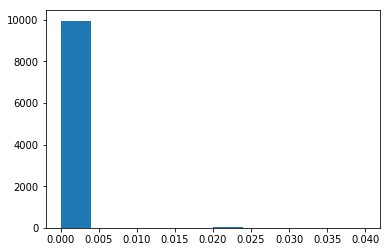

In [127]:
plt.hist(pipeline.named_steps['clf_ada'].estimators_[3].feature_importances_)

In [708]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), preprocessor=None, stop_words=None,
           strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
           tokenizer=<function tokenize at 0x7f4be1482ea0>, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf_ada',
   MultiOutputClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
             learning_rate=1.0, n_estimators=50, random_state=None),
              n_jobs=1))],
 'vect': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_

In [709]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'vect', 'tfidf', 'clf_ada', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf_ada__estimator__algorithm', 'clf_ada__estimator__base_estimator', 'clf_ada__estimator__learning_rate', 'clf_ada__estimator__n_estimators', 'clf_ada__estimator__random_state', 'clf_ada__estimator', 'clf_ada__n_jobs'])

In [34]:
count = 0
for col in y_train.columns:
    acc = accuracy_score(y_train[col],y_pred_train[:,count])
    f1 = f1_score(y_train[col],y_pred_train[:,count],average='micro')
    prec = precision_score(y_train[col],y_pred_train[:,count],average='micro')
    recall = recall_score(y_train[col],y_pred_train[:,count],average='micro')
    print('{0:.3f}, {0:.3f},  {0:.3f}, {0:.3f}    '.format(acc,f1),col)
    count += 1
    

1.000, 1.000,  1.000, 1.000     related
0.872, 0.872,  0.872, 0.872     request
0.994, 0.994,  0.994, 0.994     offer
0.739, 0.739,  0.739, 0.739     aid_related
0.912, 0.912,  0.912, 0.912     medical_help
0.949, 0.949,  0.949, 0.949     medical_products
0.970, 0.970,  0.970, 0.970     search_and_rescue
0.977, 0.977,  0.977, 0.977     security
0.968, 0.968,  0.968, 0.968     military
1.000, 1.000,  1.000, 1.000     child_alone
0.963, 0.963,  0.963, 0.963     water
0.942, 0.942,  0.942, 0.942     food
0.936, 0.936,  0.936, 0.936     shelter
0.987, 0.987,  0.987, 0.987     clothing
0.974, 0.974,  0.974, 0.974     money
0.987, 0.987,  0.987, 0.987     missing_people
0.964, 0.964,  0.964, 0.964     refugees
0.960, 0.960,  0.960, 0.960     death
0.833, 0.833,  0.833, 0.833     other_aid
0.918, 0.918,  0.918, 0.918     infrastructure_related
0.952, 0.952,  0.952, 0.952     transport
0.951, 0.951,  0.951, 0.951     buildings
0.980, 0.980,  0.980, 0.980     electricity
0.993, 0.993,  0.993, 0

In [669]:
y_pred_train

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [146]:
y_pred_test=pipeline.predict(X_test.message.values)
print(accuracy_score(y_test,y_pred_test))
print(f1_score(y_test,y_pred_test,average='micro'))
print(f1_score(y_test,y_pred_test,average='macro'))
print(f1_score(y_test,y_pred_test,average='weighted'))
print(f1_score(y_test,y_pred_test,average='samples'))

0.24539503729639214
0.7065246837685206
0.4083269170075597
0.6722270496355018
0.7194448031538635


/home/ania/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ania/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [671]:
# RandomForestClassifier() , max_feature=10000 0.2029334940727346

In [672]:
count= 0
for col in y_train.columns:
    print(col, classification_report(y_train[col].values,y_pred_train[:,count]))
    count += 1 

related              precision    recall  f1-score   support

          1       1.00      1.00      1.00     13337

avg / total       1.00      1.00      1.00     13337

request              precision    recall  f1-score   support

          0       0.89      0.95      0.92     10339
          1       0.78      0.60      0.68      2998

avg / total       0.87      0.87      0.87     13337

offer              precision    recall  f1-score   support

          0       0.99      1.00      1.00     13252
          1       0.36      0.09      0.15        85

avg / total       0.99      0.99      0.99     13337

aid_related              precision    recall  f1-score   support

          0       0.69      0.76      0.73      6080
          1       0.78      0.72      0.75      7257

avg / total       0.74      0.74      0.74     13337

medical_help              precision    recall  f1-score   support

          0       0.92      0.98      0.95     11954
          1       0.67      0.30      0

In [147]:
f1_score(y_train,y_pred_train,average='micro') #0.89 onevsall_linearsvc  #0.998 RF 100 estimator

0.7331875116072718

In [148]:
f1_score(y_test,y_pred_test,average='micro') # 0.71 onevsall_linearsvc   #0.71 RF 100 estimator

0.7065246837685206

In [705]:
list(y_test.columns)

['related',
 'request',
 'offer',
 'aid_related',
 'medical_help',
 'medical_products',
 'search_and_rescue',
 'security',
 'military',
 'child_alone',
 'water',
 'food',
 'shelter',
 'clothing',
 'money',
 'missing_people',
 'refugees',
 'death',
 'other_aid',
 'infrastructure_related',
 'transport',
 'buildings',
 'electricity',
 'tools',
 'hospitals',
 'shops',
 'aid_centers',
 'other_infrastructure',
 'weather_related',
 'floods',
 'storm',
 'fire',
 'earthquake',
 'cold',
 'other_weather',
 'direct_report']

In [149]:
print(classification_report(y_test,y_pred_test,target_names=list(y_test.columns)))

                        precision    recall  f1-score   support

               related       1.00      1.00      1.00      6569
               request       0.75      0.55      0.64      1476
                 offer       0.08      0.03      0.04        33
           aid_related       0.76      0.70      0.73      3603
          medical_help       0.66      0.27      0.38       701
      medical_products       0.68      0.32      0.44       442
     search_and_rescue       0.52      0.18      0.27       258
              security       0.20      0.05      0.08       157
              military       0.65      0.34      0.44       316
           child_alone       0.00      0.00      0.00         0
                 water       0.75      0.65      0.69       581
                  food       0.83      0.70      0.76       939
               shelter       0.79      0.51      0.62       793
              clothing       0.74      0.43      0.55       139
                 money       0.53      

/home/ania/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ania/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [57]:
count= 0 #bad:offer,medical help,medical products,search_scurity,security
for col in list(y_test.columns)[0:]:
    #print(col, classification_report(y_test[col].values,y_pred_test[:,count]))
    tup1 = precision_recall_fscore_support(y_test[col].values,y_pred_test[:,count],average='micro')
    tup2 = precision_recall_fscore_support(y_test[col].values,y_pred_test[:,count],average='macro')
    tup3 = precision_recall_fscore_support(y_test[col].values,y_pred_test[:,count],average='weighted')
    print('================================================')
    print('                ',col,'')
    print('------------------------------------------------')
    print()
    print('          %Precision     %Recall      %F1_score')
    print()
    print('Micro   ','   {0:.2f}          {0:.2f}          {0:.2f}'.format(tup1[0],tup1[1],tup1[2]))
    print('Macro   ','   {0:.2f}          {0:.2f}          {0:.2f}'.format(tup2[0],tup2[1],tup2[2]))
    print('Weighted','   {0:.2f}          {0:.2f}          {0:.2f}'.format(tup3[0],tup3[1],tup3[2]))
    print()

    count += 1 

                 related 
------------------------------------------------

          %Precision     %Recall      %F1_score

Micro       1.00          1.00          1.00
Macro       1.00          1.00          1.00
Weighted    1.00          1.00          1.00

                 request 
------------------------------------------------

          %Precision     %Recall      %F1_score

Micro       0.86          0.86          0.86
Macro       0.82          0.82          0.82
Weighted    0.85          0.85          0.85

                 offer 
------------------------------------------------

          %Precision     %Recall      %F1_score

Micro       0.99          0.99          0.99
Macro       0.50          0.50          0.50
Weighted    0.99          0.99          0.99

                 aid_related 
------------------------------------------------

          %Precision     %Recall      %F1_score

Micro       0.72          0.72          0.72
Macro       0.72          0.72          0.72


                 fire 
------------------------------------------------

          %Precision     %Recall      %F1_score

Micro       0.99          0.99          0.99
Macro       0.78          0.78          0.78
Weighted    0.98          0.98          0.98

                 earthquake 
------------------------------------------------

          %Precision     %Recall      %F1_score

Micro       0.97          0.97          0.97
Macro       0.93          0.93          0.93
Weighted    0.97          0.97          0.97

                 cold 
------------------------------------------------

          %Precision     %Recall      %F1_score

Micro       0.98          0.98          0.98
Macro       0.85          0.85          0.85
Weighted    0.97          0.97          0.97

                 other_weather 
------------------------------------------------

          %Precision     %Recall      %F1_score

Micro       0.93          0.93          0.93
Macro       0.71          0.71          0.71

In [676]:
count = 0
for col in y_test.columns:
    acc = accuracy_score(y_test[col],y_pred_test[:,count])
    f1 = f1_score(y_test[col],y_pred_test[:,count])
    prec = precision_score(y_test[col],y_pred_test[:,count])
    recall = recall_score(y_test[col],y_pred_test[:,count])
    print('{0:.3f}, {0:.3f},  {0:.3f}, {0:.3f}    '.format(acc,f1),col)
    count += 1

1.000, 1.000,  1.000, 1.000     related
0.859, 0.859,  0.859, 0.859     request
0.993, 0.993,  0.993, 0.993     offer
0.720, 0.720,  0.720, 0.720     aid_related
0.907, 0.907,  0.907, 0.907     medical_help
0.943, 0.943,  0.943, 0.943     medical_products
0.962, 0.962,  0.962, 0.962     search_and_rescue
0.974, 0.974,  0.974, 0.974     security
0.959, 0.959,  0.959, 0.959     military
1.000, 1.000,  1.000, 1.000     child_alone
0.950, 0.950,  0.950, 0.950     water
0.942, 0.942,  0.942, 0.942     food
0.930, 0.930,  0.930, 0.930     shelter
0.983, 0.983,  0.983, 0.983     clothing
0.974, 0.974,  0.974, 0.974     money
0.984, 0.984,  0.984, 0.984     missing_people
0.955, 0.955,  0.955, 0.955     refugees
0.962, 0.962,  0.962, 0.962     death
0.837, 0.837,  0.837, 0.837     other_aid
0.911, 0.911,  0.911, 0.911     infrastructure_related
0.944, 0.944,  0.944, 0.944     transport
0.947, 0.947,  0.947, 0.947     buildings
0.973, 0.973,  0.973, 0.973     electricity
0.990, 0.990,  0.990, 0

In [677]:
count = 0
for col in y_test.columns:
    print(col,'{0:.4f}'.format(f1_score(y_test[col],y_pred_test[:,count],average='micro')))
    count += 1

related 1.0000
request 0.8592
offer 0.9928
aid_related 0.7199
medical_help 0.9070
medical_products 0.9426
search_and_rescue 0.9621
security 0.9744
military 0.9591
child_alone 1.0000
water 0.9504
food 0.9423
shelter 0.9303
clothing 0.9833
money 0.9737
missing_people 0.9842
refugees 0.9551
death 0.9621
other_aid 0.8365
infrastructure_related 0.9106
transport 0.9441
buildings 0.9469
electricity 0.9734
tools 0.9901
hospitals 0.9825
shops 0.9916
aid_centers 0.9834
other_infrastructure 0.9362
weather_related 0.8545
floods 0.9426
storm 0.9272
fire 0.9868
earthquake 0.9665
cold 0.9772
other_weather 0.9271
direct_report 0.8041


In [678]:
#bridge is crashing powerline earthquake
pipeline.predict(['bridge is crashing powerline earthquake'])[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])

In [680]:
pipeline.predict(["help can't find my family missing"])[0]

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
parameters = 

cv = 

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.